In [1]:
#importing all the required lib
import pandas as pd
import numpy as np 
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,CuDNNLSTM
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras
from sklearn.utils import compute_class_weight
from keras.initializers import he_normal,glorot_normal
from keras.regularizers import l1,l2
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import TensorBoard
from IPython.display import SVG, display
import pickle 
from keras.layers import LeakyReLU
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/My Drive/Assignments/preprocessed_data.csv")
data.shape

(109248, 9)

In [5]:
dbfile = open('/content/drive/My Drive/Assignments_DonorsChoose_2018/glove_vectors', 'rb')      
db = pickle.load(dbfile)

In [6]:
print(db["good"].shape)
print(db["good"][0:10])

(300,)
[-0.069254  0.37668  -0.16958  -0.27482   0.25667  -0.20293  -4.1122
  0.02595  -0.27085  -0.87003 ]


Each word is represented as a 300X1 dim vector and we printed the first 10values of a word "good"

In [7]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [8]:
data['remaining_input'] = data['teacher_number_of_previously_posted_projects']  +\
                                 data['price']

In [9]:
data.drop(["teacher_number_of_previously_posted_projects","price"],axis = 1 ,inplace = True)

In [10]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'project_is_approved', 'clean_categories', 'clean_subcategories',
       'essay', 'remaining_input'],
      dtype='object')

In [11]:
y=data["project_is_approved"]
data.drop("project_is_approved",axis = 1,inplace=True)
print(f"Target:{y.shape}\n Input {data.shape}")

Target:(109248,)
 Input (109248, 7)


Now let's investigate each features 

In [12]:
cols = data.columns
for col in cols:
  print(f"{col}:{data[col].describe()}\n{data[col].unique()}")
  print("*"*100)

school_state:count     109248
unique        51
top           ca
freq       15388
Name: school_state, dtype: object
['ca' 'ut' 'ga' 'wa' 'hi' 'il' 'oh' 'ky' 'sc' 'fl' 'mo' 'mi' 'ny' 'va'
 'md' 'tx' 'ms' 'nj' 'az' 'ok' 'pa' 'wv' 'nc' 'co' 'dc' 'ma' 'id' 'al'
 'me' 'tn' 'in' 'la' 'ct' 'ar' 'ks' 'or' 'wi' 'ia' 'sd' 'ak' 'mn' 'nm'
 'nv' 'mt' 'ri' 'nh' 'wy' 'ne' 'de' 'nd' 'vt']
****************************************************************************************************
teacher_prefix:count     109248
unique         5
top          mrs
freq       57272
Name: teacher_prefix, dtype: object
['mrs' 'ms' 'mr' 'teacher' 'dr']
****************************************************************************************************
project_grade_category:count            109248
unique                4
top       grades_prek_2
freq              44225
Name: project_grade_category, dtype: object
['grades_prek_2' 'grades_3_5' 'grades_9_12' 'grades_6_8']
**************************************************

# Splitting our data into train and test

In [13]:
# Split Train, CV and Test data (64, 16, 20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=y,random_state=5)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train,random_state=5)

print('Train Data', X_train.shape, y_train.shape)
print('Cross-Validation Data', X_cv.shape, y_cv.shape)
print('Test Data', X_test.shape, y_test.shape)

Train Data (69918, 7) (69918,)
Cross-Validation Data (17480, 7) (17480,)
Test Data (21850, 7) (21850,)


In [14]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_cv = to_categorical(y_cv)
y_test = to_categorical(y_test)

In [15]:
y_train.shape

(69918, 2)

Now let's prepare our features for embedding

Cateogrical Featurization

In [17]:
from sklearn.preprocessing import LabelEncoder
class LabelEncoderExt(object):
      def __init__(self):
         self.label_encoder = LabelEncoder()
      # self.classes_ = self.label_encoder.classes_
      def fit(self, data_list):
     
          self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
          self.classes_ = self.label_encoder.classes_
          return self
      def transform(self, data_list):
      
          new_data_list = list(data_list)
          for unique_item in np.unique(data_list):
              if unique_item not in self.label_encoder.classes_:
                      new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]
          return self.label_encoder.transform(new_data_list)

In [18]:
from keras.preprocessing import sequence
train_sch_state = X_train.school_state.values
test_sch_state = X_test.school_state.values
cv_sch_state = X_cv.school_state.values
# tokenizer = Tokenizer() #using the TOkenizer function creating an object tokenizer
# tokenizer.fit_on_texts(train_sch_state)#training on train data
# train_sch_state = tokenizer.texts_to_sequences(train_sch_state)#converting text to squences 
# test_sch_state = tokenizer.texts_to_sequences(test_sch_state)
# cv_sch_state = tokenizer.texts_to_sequences(cv_sch_state)
# x_train_sch_state = sequence.pad_sequences(train_sch_state, maxlen = max_length, padding='post')
# x_test_sch_state = sequence.pad_sequences(test_sch_state, maxlen = max_length, padding='post')
# x_cv_sch_state = sequence.pad_sequences(cv_sch_state, maxlen = max_length, padding='post')

In [19]:
le1=LabelEncoderExt()
le1.fit(train_sch_state)
x_train_sch_state=le1.transform(train_sch_state)
x_cv_sch_state=le1.transform(cv_sch_state)
x_test_sch_state=le1.transform(test_sch_state)


In [20]:
train_proj_grade = X_train.project_grade_category.values
test_proj_grade = X_test.project_grade_category.values
cv_proj_grade = X_cv.project_grade_category.values
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(train_proj_grade)
# train_proj_grade = tokenizer.texts_to_sequences(train_proj_grade)
# test_proj_grade = tokenizer.texts_to_sequences(test_proj_grade)
# cv_proj_grade = tokenizer.texts_to_sequences(cv_proj_grade)
# x_train_proj_grade = sequence.pad_sequences(train_proj_grade, maxlen = max_length, padding='post')
# x_test_proj_grade = sequence.pad_sequences(test_proj_grade, maxlen = max_length, padding='post')
# x_cv_proj_grade = sequence.pad_sequences(cv_proj_grade, maxlen = max_length, padding='post')
le1=LabelEncoderExt()
le1.fit(train_proj_grade)
x_train_proj_grade=le1.transform(train_proj_grade)
x_cv_proj_grade=le1.transform(cv_proj_grade)
x_test_proj_grade=le1.transform(test_proj_grade)

We can see that each state  is converted into numeric using text to sequences
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [21]:
train_clean_cat = X_train.clean_categories.values
test_clean_cat = X_test.clean_categories.values
cv_clean_cat = X_cv.clean_categories.values
le1=LabelEncoderExt()
le1.fit(train_clean_cat)
x_train_clean_cat=le1.transform(train_clean_cat)
x_cv_clean_cat=le1.transform(cv_clean_cat)
x_test_clean_cat=le1.transform(test_clean_cat)

In [22]:
train_clean_sub_cat = X_train.clean_subcategories.values
test_clean_sub_cat = X_test.clean_subcategories.values
cv_clean_sub_cat = X_cv.clean_subcategories.values
le1=LabelEncoderExt()
le1.fit(train_clean_sub_cat)
x_train_clean_sub_cat=le1.transform(train_clean_sub_cat)
x_cv_clean_sub_cat=le1.transform(cv_clean_sub_cat)
x_test_clean_sub_cat=le1.transform(test_clean_sub_cat)


In [23]:
train_teacher_prefix = X_train.teacher_prefix.values
test_teacher_prefix = X_test.teacher_prefix.values
cv_teacher_prefix = X_cv.teacher_prefix.values
le1=LabelEncoderExt()
le1.fit(train_teacher_prefix)
x_train_teacher_prefix=le1.transform(train_teacher_prefix)
x_cv_teacher_prefix=le1.transform(cv_teacher_prefix)
x_test_teacher_prefix=le1.transform(test_teacher_prefix)

#Numerical Featurization

In [24]:
X_train["remaining_input"] = X_train["remaining_input"].values.reshape(-1,1)
X_train["remaining_input"].shape
from sklearn.preprocessing import MinMaxScaler , StandardScaler

scalar = StandardScaler()
scalar.fit(X_train["remaining_input"].values.reshape(-1,1))
x_train_num = scalar.transform(X_train["remaining_input"].values.reshape(-1,1))
x_test_num = scalar.transform(X_test["remaining_input"].values.reshape(-1,1))
x_cv_num = scalar.transform(X_cv["remaining_input"].values.reshape(-1,1))
print(x_train_num.shape)
print(x_train_num)


(69918, 1)
[[-0.33347414]
 [-0.56713156]
 [ 3.04850062]
 ...
 [ 0.18106669]
 [-0.43048112]
 [-0.43015144]]


# Text Data Vectorization

In [25]:
x_train_essay_text = X_train.essay.values.tolist()
x_test_essay_text = X_test.essay.values.tolist()
x_cv_essay_text = X_cv.essay.values.tolist()
print(len(max(x_train_essay_text)))

910


In [26]:
# tokenizing 
# https://stackoverflow.com/questions/52126539/using-pretrained-gensim-word2vec-embedding-in-keras
# https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/
#t = Tokenizer()
#t.fit_on_texts(x_train_essay_text)
#vocab_size = len(t.word_index) + 1
#print(len(t.word_index))

In [ ]:
#vocab_size

In [27]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def padded(encoded_docs):  
  max_length = 400
  padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
  return padded_docs

In [28]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(x_train_essay_text)
vocab_size = len(t.word_index) + 1
print(vocab_size)
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_train_essay_text)
essay_padded_train = padded(encoded_docs)

47243


In [29]:
vocab_size

47243

In [30]:
essay_padded_train.shape

(69918, 400)

In [31]:
#t = Tokenizer()
#t.fit_on_texts(x_cross.cleaned_essay)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_cv_essay_text)
essay_padded_cv = padded(encoded_docs)

In [32]:
#t = Tokenizer()
#t.fit_on_texts(x_test.cleaned_essay)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(x_test_essay_text)
essay_padded_test = padded(encoded_docs)

In [33]:
print(essay_padded_train.shape)
print(essay_padded_test.shape)
print(essay_padded_cv.shape)

(69918, 400)
(21850, 400)
(17480, 400)


In [34]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = db.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [35]:
embedding_matrix.shape

(47243, 300)

In [36]:
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def auroc(y_true, y_pred):
    # print(y_true, y_pred)
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [46]:
from keras.optimizers import Adam
#input 1
input_1 = Input(shape=(400,))
x1 =Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=400, trainable=False)(input_1)
#what are spartial dropouts - https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
#https://stackoverflow.com/questions/50393666/how-to-understand-spatialdropout1d-and-when-to-use-it
x1 = LSTM(100,return_sequences=True, activation = 'relu',recurrent_dropout=0.5,kernel_regularizer=l2(0.001))(x1)
#x1= LeakyReLU(alpha = 0.3)(x1)
x1 = Flatten()(x1)

#input 2
input_2 = Input(shape=(1,))#school_state
x2 = Embedding(input_dim= 52, output_dim= min(52//2,50))(input_2)
x2 = Flatten()(x2)

#input 3
input_3 = Input(shape=(1,)) #project_grade
x3 = Embedding(input_dim = 52, output_dim= min(52//2,50))(input_3)
x3 = Flatten()(x3)

#input 4
input_4 = Input(shape=(1,)) #clean_categories
x4 = Embedding(input_dim=52,output_dim= min(52//2,50))(input_4)
x4 = Flatten()(x4)

#input 5
input_5 = Input(shape=(1,)) #clean_subcategories
x5 = Embedding(input_dim= 390, output_dim= min(390//2,50))(input_5)
x5 = Flatten()(x5)

#input 6
input_6 = Input(shape=(1,))#teacher_prefix
x6 = Embedding(input_dim= 6,output_dim= min(6//2,50))(input_6)
x6 = Flatten()(x6)

#input 7
input_7 = Input(shape=(1,)) #numerical
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input_7)

#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
x = BatchNormalization()(concat)

x = Dense(256,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x= LeakyReLU(alpha = 0.3)(x)
x = Dropout(0.6)(x)
x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU(alpha = 0.3)(x)
x = Dropout(0.5)(x)
x = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU(alpha = 0.3)(x)
x = Dropout(0.5)(x)
x = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU(alpha = 0.3)(x)
x = Dropout(0.5)(x)
#x = Dense(16,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
#x = LeakyReLU(alpha = 0.3)(x)
output = Dense(2, activation = 'softmax')(x)

# model with all the inputs
model1 = Model([input_1, input_2, input_3, input_4, input_5, input_6, input_7], output)
model1.run_eagerly = True
#tensorboard = TensorBoard(log_dir="logs".format(time()))
tensorboard = TensorBoard(log_dir="/content/drive/My Drive/LSTM_Output/logs/{}".format(time()))
model1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0006,decay = 1e-4), metrics=[auroc])
print(model1.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 400, 300)     14172900    input_22[0][0]                   
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

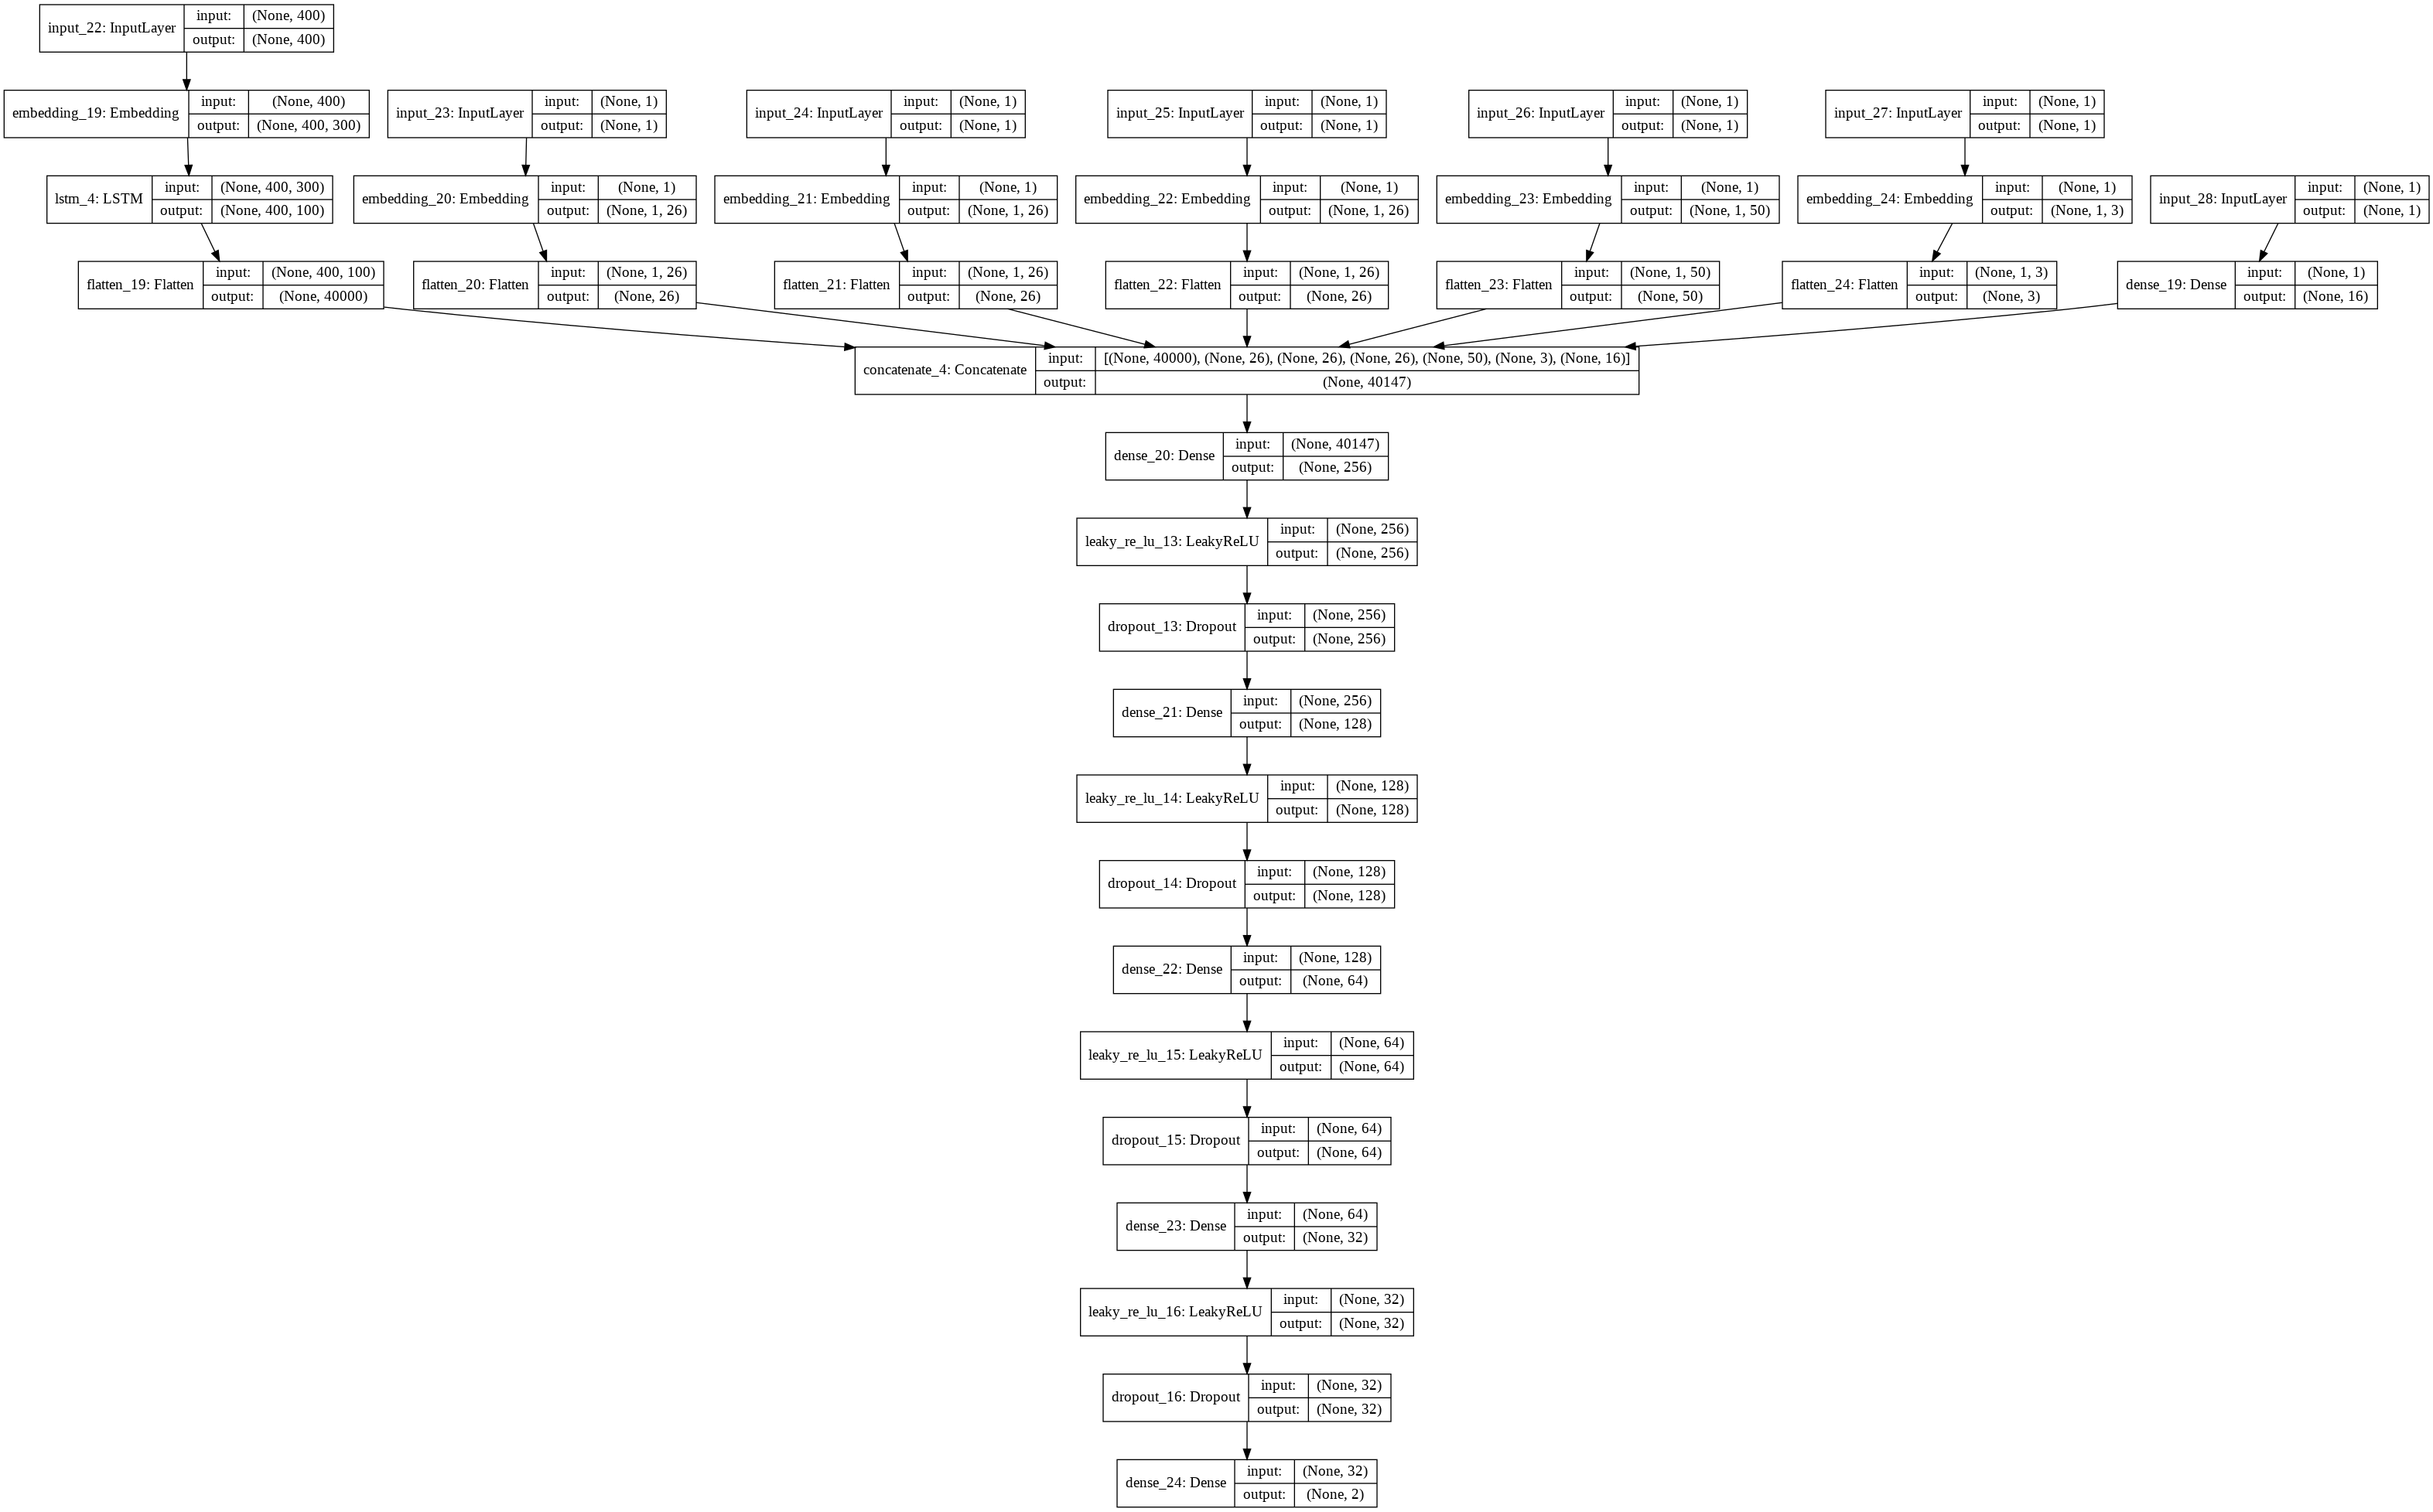

In [47]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='/content/drive/My Drive/LSTM_Output/model_1.png', show_shapes=True, show_layer_names=True)

In [42]:
x_train = [essay_padded_train ,x_train_sch_state,x_train_proj_grade,x_train_clean_cat,x_train_clean_sub_cat,x_train_teacher_prefix,x_train_num]
x_test = [essay_padded_test,x_test_sch_state,x_test_proj_grade,x_test_clean_cat,x_test_clean_sub_cat,x_test_teacher_prefix,x_test_num]
x_cv = [essay_padded_cv ,x_cv_sch_state,x_cv_proj_grade,x_cv_clean_cat,x_cv_clean_sub_cat,x_cv_teacher_prefix,x_cv_num]

In [48]:
adam = keras.optimizers.Adam(lr=0.0006)
model1.compile(optimizer=adam, loss='categorical_crossentropy',metrics=[auroc])

In [49]:
from keras.callbacks import *
filepath="/content/drive/My Drive/LSTM_Output/model1/epochs:{epoch:03d}-val_acc:{val_auroc:.3f}.hdf5"
checkpoint_1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max')

In [50]:
filepath = "/content/drive/My Drive/weights_2.best.hdf5"
earlystopping1 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

#checkpoint2 = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
tensorboard = TensorBoard(log_dir="/content/drive/My Drive/LSTM_Output/logs/{}".format(time()))
callbacks_list = [checkpoint_1,tensorboard, earlystopping1]#, reduce_lr2]

history1= model1.fit(x_train, y_train, epochs=20, verbose=1, batch_size=300, validation_data=(x_cv  , y_cv),callbacks=callbacks_list)
#model2.save('/content/drive/My Drive/weights_2.best.hdf5')

Train on 69918 samples, validate on 17480 samples
Epoch 1/20
69918/69918 [==============================] - 180s 3ms/step - loss: 0.7282 - auroc: 0.6022 - val_loss: 0.5247 - val_auroc: 0.7180

Epoch 00001: saving model to /content/drive/My Drive/LSTM_Output/model1/epochs:001-val_acc:0.718.hdf5
Epoch 2/20
69918/69918 [==============================] - 174s 2ms/step - loss: 0.5044 - auroc: 0.7033 - val_loss: 0.4768 - val_auroc: 0.7261

Epoch 00002: saving model to /content/drive/My Drive/LSTM_Output/model1/epochs:002-val_acc:0.726.hdf5
Epoch 3/20
69918/69918 [==============================] - 173s 2ms/step - loss: 0.4662 - auroc: 0.7279 - val_loss: 0.4521 - val_auroc: 0.7323

Epoch 00003: saving model to /content/drive/My Drive/LSTM_Output/model1/epochs:003-val_acc:0.732.hdf5
Epoch 4/20
69918/69918 [==============================] - 181s 3ms/step - loss: 0.4463 - auroc: 0.7451 - val_loss: 0.4430 - val_auroc: 0.7354

Epoch 00004: saving model to /content/drive/My Drive/LSTM_Output/model1/

In [51]:
from keras.optimizers import Adam
#input 1
input_1 = Input(shape=(400,))
x1 =Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=400, trainable=False)(input_1)
#what are spartial dropouts - https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
#https://stackoverflow.com/questions/50393666/how-to-understand-spatialdropout1d-and-when-to-use-it
x1 = LSTM(100,return_sequences=True, activation = 'relu',recurrent_dropout=0.5,kernel_regularizer=l2(0.001))(x1)
#x1= LeakyReLU(alpha = 0.3)(x1)
x1 = Flatten()(x1)

#input 2
input_2 = Input(shape=(1,))#school_state
x2 = Embedding(input_dim= 52, output_dim= min(52//2,50))(input_2)
x2 = Flatten()(x2)

#input 3
input_3 = Input(shape=(1,)) #project_grade
x3 = Embedding(input_dim = 52, output_dim= min(52//2,50))(input_3)
x3 = Flatten()(x3)

#input 4
input_4 = Input(shape=(1,)) #clean_categories
x4 = Embedding(input_dim=52,output_dim= min(52//2,50))(input_4)
x4 = Flatten()(x4)

#input 5
input_5 = Input(shape=(1,)) #clean_subcategories
x5 = Embedding(input_dim= 390, output_dim= min(390//2,50))(input_5)
x5 = Flatten()(x5)

#input 6
input_6 = Input(shape=(1,))#teacher_prefix
x6 = Embedding(input_dim= 6,output_dim= min(6//2,50))(input_6)
x6 = Flatten()(x6)

#input 7
input_7 = Input(shape=(1,)) #numerical
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input_7)

#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
x = BatchNormalization()(concat)

x = Dense(256,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x= LeakyReLU(alpha = 0.3)(x)
x = Dropout(0.6)(x)
x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU(alpha = 0.3)(x)
x = Dropout(0.5)(x)
x = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU(alpha = 0.3)(x)
x = Dropout(0.5)(x)
x = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU(alpha = 0.3)(x)
x = Dropout(0.5)(x)
#x = Dense(16,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
#x = LeakyReLU(alpha = 0.3)(x)
output = Dense(2, activation = 'softmax')(x)

# model with all the inputs
model1 = Model([input_1, input_2, input_3, input_4, input_5, input_6, input_7], output)
model1.run_eagerly = True
#tensorboard = TensorBoard(log_dir="logs".format(time()))
tensorboard = TensorBoard(log_dir="/content/drive/My Drive/LSTM_Output/logs/{}".format(time()))
#model1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0006,decay = 1e-4), metrics=[auroc])
#print(model1.summary())
model1.load_weights("/content/drive/My Drive/LSTM_Output/model1/epochs:005-val_acc:0.737.hdf5")

In [53]:
print("Auc for test data: %0.3f"%roc_auc_score(y_test,model1.predict(x_test)))
print("Auc for CV data: %0.3f"%roc_auc_score(y_cv,model1.predict(x_cv)))
print("Auc for train data: %0.3f"%roc_auc_score(y_train,model1.predict(x_train)))

Auc for test data: 0.752
Auc for CV data: 0.737
Auc for train data: 0.788


In [54]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

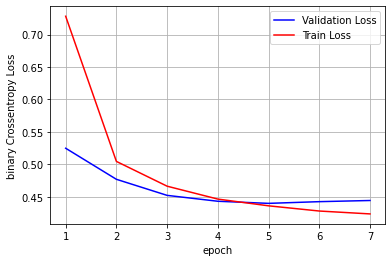

In [56]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,7+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history1.history['val_loss']
ty = history1.history['loss']
plt_dynamic(x, vy, ty, ax)

In [59]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Auroc")
    ax.plot(x, ty, 'r', label="Train Auroc")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

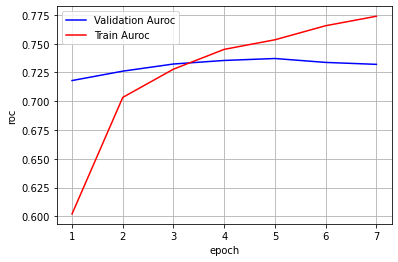

In [61]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('roc')

# list of epoch numbers
x = list(range(1,7+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history1.history['val_auroc']
ty = history1.history['auroc']
plt_dynamic(x, vy, ty, ax)

#Observation

We can see that at first both the training and validation losses are decreasing but after epoch reaches to 5 validation loss increases again but training loss keeps on decreasing